In [1]:
# Importing the necessary packages
import os  # Provides functions to interact with the operating system
import cv2 # OpenCV library for computer vision and image processing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Defining the labels of the 10 folders (including 9_c2, excluding 9_c)
gesture_labels = {
    "01_palm": 0, "02_l": 1, "03_fist": 2, "04_fist_moved": 3, "05_thumb": 4,
    "06_index": 5, "07_ok": 6, "08_palm_moved": 7, "09_c": 8, "10_down": 9
}

In [3]:
# Loading images with filters and padding
# Defining function to load and process images for gesture recognition
def load_images(gesture_labels, target_size=(64, 64), padding_size=2, include_custom=True):
    '''
    This function loads images from folders named in gesture_labels, 
    processes them with filters and padding, and returns them as NumPy arrays for machine learning.
    inputs:
    gesture_labels (dictionary above), 
    target_size (default 64 x 64 pixels)
    padding_size (Pixels to add around edges)
    '''
    
    # Empty lists ro store processed data
    images = []
    labels = []
    
    # Initializing the class_counts at the function level
    class_counts = {label: 0 for label in gesture_labels.values()}
    
    # Base path to the leapGestRecog/leapGestRecog directory
    base_path = os.path.join(os.getcwd(), "archive (1)", "leapGestRecog", "leapGestRecog")
    print(f"Base path: {base_path}")
    
    
    # Creating CLAHE object for adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    
    
    # This folder loops through each gesture folder in gesture_labels
    # it skips missing folders with a warning sign printed
    # builds full folder path using os
    for numbered_folder in os.listdir(base_path):
        numbered_path = os.path.join(base_path, numbered_folder)
        if not os.path.isdir(numbered_path) or not numbered_folder.isdigit():
            print(f"Skipping {numbered_path} - not a numbered directory")
            continue
            
        print(f"Processing numbered folder: {numbered_folder}")
        
        # Loop through gesture subfolders inside each numbered folder
        for folder in os.listdir(numbered_path):
            if folder not in gesture_labels:
                print(f"Skipping {folder} - not in gesture_labels")
                continue
                
            folder_path = os.path.join(numbered_path, folder)
            if not os.path.isdir(folder_path):
                print(f"This: {folder_path} not found, we are skipping.")
                continue
                
            img_count = 0 # Tracking each images per folder
            
            print(f"Checking folder: {folder_path}")
            files = os.listdir(folder_path)
            print(f"Found {len(files)} files in {folder}")
            
            
            # Image processing loop:
            # Processing each image in the folder
            '''
            This for loop filters for image files (PNG, JPG, JPEG),
            it loads each image in grayscale using OpenCV (cv2)
            it will skip if loading fails
            '''
            
            for img_name in files:
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                    
                    
                # This is full image path
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Loading the image as grayscale
                
                
                     
                '''
                This if statement resizes images to 64x64 pixels
                adds 2 pixel black padding (making it 68 x 68 temporarily)
                applies gaussian blur to reduce noise in the background
                uses sobel filters to detect edges (horizontal and vertical)
                combines edges into a single edge map
                blends original image (padded) with edges (50 / 50 mix)
                crops back to 64 x 64 by removing the padding
                '''
                
                if img is not None: # This is to check that image has loaded successfully
                    img = cv2.equalizeHist(img) # Enhance contrast
                    img_orig = cv2.resize(img, target_size) # Resizing original to 64 x 64
                    img = cv2.resize(img, target_size) # Resizing the working copy
                    
                    img = cv2.copyMakeBorder(img, padding_size, padding_size, padding_size, padding_size, 
                                             cv2.BORDER_CONSTANT, value=0)
                    
                    
                    # Applying filters for edge detection
                    '''
                    Why: GaussianBlur
                    In gesture recognition, raw images might contain noise from lighting variations, 
                    sensor imperfections, or background clutter. Smoothing reduces these distractions,
                    making the subsequent edge detection more reliable by focusing on significant structural 
                    features
    
                    '''
                    #img_blur = cv2.GaussianBlur(img, (3, 3), 0) # To smooth each image
                    '''
                    3x3 kernel, meaning it averages each pixel with its immediate neighbors,
                    providing moderate smoothing without overly blurring the image.
                    0: ensures a balanced blur
                    '''
                    
                    '''
                    Sobel filters: 
                    detect edges by calculating the gradient (rate of intensity change) in the image—sobel_x for horizontal edges and sobel_y for vertical edges.
                    Reason: In gesture recognition, the shape and boundaries of the hand or fingers are critical features. Edges highlight these boundaries, distinguishing the gesture from the background. For example:
                    Horizontal edges might capture the top or bottom of a palm.
                    Vertical edges might outline fingers or the sides of the hand.
                    
                    Summary: 
                    Extracts structural information (edges) 
                    that a neural network can use to differentiate gestures like "palm" from "fist.
                    '''
                    
                    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3) # Horizontal Edges
                    
                    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3) # Vertical Edges
                    
                    
                    '''
                    Creates a unified edge image that captures the full outline of the gesture,
                    enhancing feature extraction.
                    '''
                    
                    sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
                    
                    
                    img_edges = np.uint8(sobel_combined) # Converting to 8-bit image
                    
                    
                    
                    # Pad original to match processed size
                    img = cv2.copyMakeBorder(img_orig, padding_size, padding_size, padding_size, padding_size, 
                                             cv2.BORDER_CONSTANT, value=0)
                    
                    
                    '''
                    Combines the original padded image (img) with the edge map (img_edges) in a 50/50 ratio.
                    Reason: While edges are crucial for gesture recognition, the original image contains additional
                    context (e.g: texture, shading) that might help distinguish subtle differences between gestures (e.g: "palm" vs. "palm_moved"). 
                    Blending preserves both:
                    Edges emphasize boundaries and shapes.
                    Original image retains some internal details.
                    '''
                
                    # Blending original and edges (50/50 mix)
                    '''Changes .5 to .7
                    '''
                    img = (0.9 * img + 0.1 * img_edges).astype(np.uint8)
                    
                    
                    # Cropping back to target_size (removing padding)
                    img = img[padding_size:-padding_size, padding_size:-padding_size] # Crop to 64x64
                    
                    
                    # Storing processed image
                    '''
                    This adds processed image and label to lists
                    and track count per folder
                    '''
                    images.append(img)
                    
                    # Store its label
                    labels.append(gesture_labels[folder])
                    class_counts[gesture_labels[folder]] += 1
                    img_count += 1
                else:
                    print(f"Failed to load {img_path}")
                    
            print(f"Loaded {img_count} images from {folder}")
            
    # Loading the custom data (images added)
    if include_custom:
        
        custom_path = os.path.join(os.getcwd(), "custom_data")
        
        if os.path.exists(custom_path):
            print(f"Loading custom data from: {custom_path}")
            
            for img_name in os.listdir(custom_path):
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                    
                    
                # Extract full gesture name (e.g., "04_fist_moved")
                parts = img_name.split('_')
                
                if len(parts) < 3:  # Ensure filename has at least 3 parts (e.g., 04_fist_moved_timestamp)
                    print(f"Skipping {img_name} - invalid filename format")
                    continue
                    
                    
                gesture_name = '_'.join(parts[:-1])  # Join all parts except the last (timestamp)
                if gesture_name not in gesture_labels:
                    print(f"Skipping {img_name} - gesture {gesture_name} not in gesture_labels")
                    continue
                    
                    
                img_path = os.path.join(custom_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img is not None:
                    img = cv2.equalizeHist(img)
                    img_orig = cv2.resize(img, target_size)
                    img = cv2.resize(img, target_size)
                    img = cv2.copyMakeBorder(img, padding_size, padding_size, padding_size, padding_size, 
                                             cv2.BORDER_CONSTANT, value=0)
                    img_blur = cv2.GaussianBlur(img, (3, 3), 0)
                    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
                    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
                    sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
                    img_edges = np.uint8(sobel_combined)
                    
                    img = cv2.copyMakeBorder(img_orig, padding_size, padding_size, padding_size, padding_size, 
                                             cv2.BORDER_CONSTANT, value=0)
                    img = (0.9 * img + 0.1 * img_edges).astype(np.uint8)
                    img = img[padding_size:-padding_size, padding_size:-padding_size]
                    images.append(img)
                    labels.append(gesture_labels[gesture_name])
                    class_counts[gesture_labels[gesture_name]] += 1
                    
                else:
                    print(f"Failed to load {img_path}")
    
    
    print("Final class distribution:", class_counts)
    return np.array(images), np.array(labels)


In [4]:
# Load images
target_size = (64, 64)
images, labels = load_images(gesture_labels, target_size)
print(f"Total loaded: {len(images)} images with shape {images.shape}")

Base path: C:\Users\pcortes\Neural Networks\Project1\archive (1)\leapGestRecog\leapGestRecog
Processing numbered folder: 00
Checking folder: C:\Users\pcortes\Neural Networks\Project1\archive (1)\leapGestRecog\leapGestRecog\00\01_palm
Found 201 files in 01_palm
Loaded 200 images from 01_palm
Checking folder: C:\Users\pcortes\Neural Networks\Project1\archive (1)\leapGestRecog\leapGestRecog\00\02_l
Found 200 files in 02_l
Loaded 200 images from 02_l
Checking folder: C:\Users\pcortes\Neural Networks\Project1\archive (1)\leapGestRecog\leapGestRecog\00\03_fist
Found 201 files in 03_fist
Loaded 200 images from 03_fist
Checking folder: C:\Users\pcortes\Neural Networks\Project1\archive (1)\leapGestRecog\leapGestRecog\00\04_fist_moved
Found 200 files in 04_fist_moved
Loaded 200 images from 04_fist_moved
Checking folder: C:\Users\pcortes\Neural Networks\Project1\archive (1)\leapGestRecog\leapGestRecog\00\05_thumb
Found 200 files in 05_thumb
Loaded 200 images from 05_thumb
Checking folder: C:\User

In [5]:
# Verifying the class distribution
unique, counts = np.unique(labels, return_counts=True)
print("Label distribution:", dict(zip(unique, counts)))

Label distribution: {0: 2008, 1: 2006, 2: 2006, 3: 2005, 4: 2005, 5: 2006, 6: 2005, 7: 2006, 8: 2007, 9: 2009}


In [6]:
# Normalizing the images
# Scaling pixel values from 0-255 to 0-1 better for CNN Performance
images = images.astype('float32') / 255.0


In [7]:
# Reshaping for the CNN Input
# Adding a channel dimension (grayscale = 1 channel) 

images = images.reshape(-1, target_size[0], target_size[1], 1)
print(f"New shape: {images.shape}")

New shape: (20063, 64, 64, 1)


In [8]:
# Splitting the dataset into training, validation, and test sets
# Resulting: training 70%, Validation 15%, Testing 15%

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Printing the shape of the datasets
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (14044, 64, 64, 1), Val: (3009, 64, 64, 1), Test: (3010, 64, 64, 1)


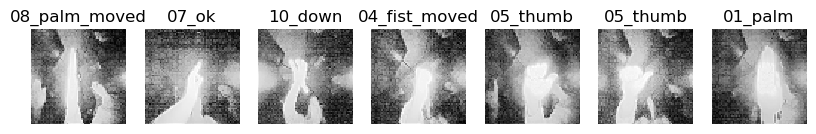

In [9]:
def plot_images(images, labels, gesture_labels, num=7):
    '''
    This function will display a row of sample images with their corresponding gesture labels.
    Visualizing the data after applying the filters will help spot issues in preprocessing
    (ex: incorrect sizing, normalization etc)
    '''
    
    plt.figure(figsize=(10, 2))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(images[i].reshape(target_size), cmap='gray')
        plt.title(list(gesture_labels.keys())[labels[i]])
        plt.axis('off')
    plt.show()

plot_images(X_train, y_train, gesture_labels)

In [ ]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,        # Simulate hand rotation
    width_shift_range=0.1,    # Horizontal shifts
    height_shift_range=0.1,   # Vertical shifts
    horizontal_flip=True,     # Left/right hand variations
    brightness_range=[0.8, 1.2],  # Lighting changes
    fill_mode='nearest'       # Fill new pixels
)
datagen.fit(X_train)

In [ ]:
np.save('X_train_filtered_padded_blended.npy', X_train)
np.save('X_val_filtered_padded_blended.npy', X_val)
np.save('X_test_filtered_padded_blended.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)

### Modelling

In [10]:
# Importing Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt




# Defining the CNN model
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),                   # Reducing spatial dimensions
    
    
    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),  # 64 filters, 3x3 kernel
    MaxPooling2D((2, 2)),
    
    # Third convolutional block
    Conv2D(128, (3, 3), activation='relu'), # 128 filters, 3x3 kernel
    MaxPooling2D((2, 2)),
    
    
    # Fully connected layers
    Flatten(),                            # Converts 3D Feature maps to 1D Vector
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),        # 128 neurons with ReLu
    Dropout(0.5),                         # Drops 50% of connections to prev. overfitting
    Dense(10, activation='softmax')       # Output layer: 10 classes with softmax
])



# Compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])      # To track accuracy during training



In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
history = model.fit(X_train, y_train, batch_size=32, 
                    epochs=30, 
                    validation_data=(X_val, y_val), 
                    )

Train on 14044 samples, validate on 3009 samples
Epoch 1/30
14044/14044 [==============================] - 140s 10ms/sample - loss: 2.3044 - accuracy: 0.0967 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/30
14044/14044 [==============================] - 158s 11ms/sample - loss: 2.3033 - accuracy: 0.0978 - val_loss: 2.3026 - val_accuracy: 0.1004
Epoch 3/30
14044/14044 [==============================] - 164s 12ms/sample - loss: 1.8494 - accuracy: 0.2970 - val_loss: 0.4106 - val_accuracy: 0.9030
Epoch 4/30
14044/14044 [==============================] - 149s 11ms/sample - loss: 0.3532 - accuracy: 0.8824 - val_loss: 0.0809 - val_accuracy: 0.9797
Epoch 5/30
14044/14044 [==============================] - 159s 11ms/sample - loss: 0.1382 - accuracy: 0.9561 - val_loss: 0.0425 - val_accuracy: 0.9920
Epoch 6/30
14044/14044 [==============================] - 244s 17ms/sample - loss: 0.0896 - accuracy: 0.9719 - val_loss: 0.0335 - val_accuracy: 0.9937
Epoch 7/30
14044/14044 [=====================

In [14]:
# Evaluating on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

3010/3010 [==============================] - 6s 2ms/sample - loss: 0.0101 - accuracy: 0.9973
Test Accuracy: 0.9973


In [15]:
# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_test, predicted_labels, target_names=gesture_labels.keys()))

Confusion Matrix:
 [[301   0   0   0   0   0   0   0   0   0]
 [  0 300   0   0   0   0   0   1   0   0]
 [  0   0 301   0   0   0   0   0   0   0]
 [  0   0   1 300   0   0   0   0   0   0]
 [  0   0   1   0 299   0   0   0   0   0]
 [  0   0   0   1   0 300   0   0   0   0]
 [  0   0   0   0   0   0 300   1   0   0]
 [  0   0   0   1   0   0   0 300   0   0]
 [  0   0   0   0   0   0   0   0 301   0]
 [  0   0   1   0   1   0   0   0   0 300]]
Classification Report:
                precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       301
         02_l       1.00      1.00      1.00       301
      03_fist       0.99      1.00      1.00       301
04_fist_moved       0.99      1.00      1.00       301
     05_thumb       1.00      1.00      1.00       300
     06_index       1.00      1.00      1.00       301
        07_ok       1.00      1.00      1.00       301
08_palm_moved       0.99      1.00      1.00       301
         09_c       1.00      

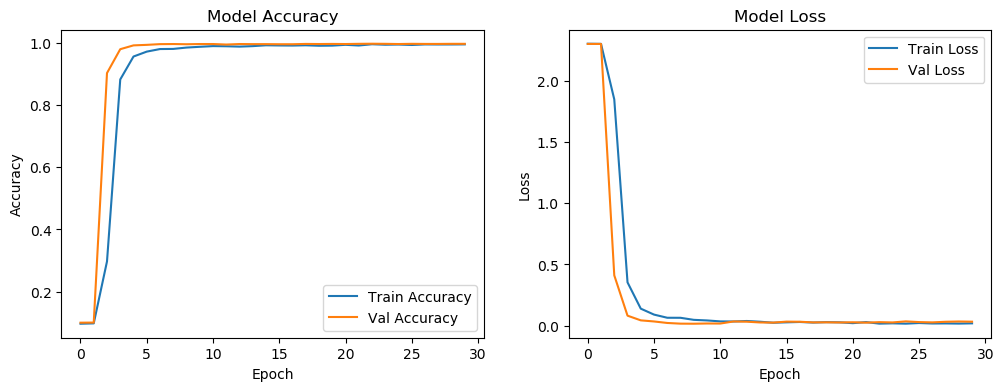

In [16]:
# Plotting the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Testing 
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
print("First 10 predicted labels:", predicted_labels[:10])
print("First 10 true labels:", y_test[:10])

First 10 predicted labels: [6 8 9 4 1 5 0 0 1 9]
First 10 true labels: [6 8 9 4 1 5 0 0 1 9]


In [18]:
# Saving the model
model.save('hand_gesture_cnn.h5')